In [109]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import warnings
from collections import Counter, defaultdict
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='white', rc={"font.family": "DejaVu Serif"})

In [100]:
print(pd.__version__)

2.2.3


# Load, format, and regress data

## Spike decoding method

In [58]:
def regress_spikes_general(variables, data_type, cross_validate, alpha=1.0):

    predictions = []
    for monkey in ['V', 'W']:
        for session in range(4):
            session_data = {}
            for block in range(1, 25):
                session_data[block] = {}
                try:
                    file = f"monkey{monkey}_session{session}_block{block}"
                    if data_type == 'monkey':
                        for trial in range(1, 81):
                            x = np.load(f"data/emp/{file}_trial{trial}_spikes_choice.npz")['spikes']
                            y_dict = pd.read_pickle(f"data/rl/{file}_trial{trial}_values.pkl")
                            session_data[block][trial] = (x, {v: y_dict[v] for v in variables})
                    elif data_type == 'nef':
                        with open(f"data/nef/{file}_spikes.pkl", "rb") as f:
                            spikes = pickle.load(f)
                        for trial in range(1, 81):
                            x = spikes[trial]
                            y_dict = pd.read_pickle(f'data/nef/{file}_values.pkl').query("trial==@trial")
                            session_data[block][trial] = (x, {v: y_dict[v] for v in variables})
                except Exception:
                    session_data[block] = None
            session_data = {b: d for b, d in session_data.items() if d and len(d) == 80}
            blocks = sorted(session_data.keys())  # Remove incomplete blocks

            #Loop over held-out blocks (or just one pass if no CV)
            loop_blocks = blocks if cross_validate else [None]
            for block_out in loop_blocks:
                # Prepare training data
                X_train = []
                Y_train = {v: [] for v in variables}
                for block in blocks:
                    if block == block_out:
                        continue
                    for trial, (x, y_dict) in session_data[block].items():
                        X_train.append(x)
                        for v in variables:
                            Y_train[v].append(y_dict[v])
                # Fit Ridge models
                models = {}
                for v in variables:
                    model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
                    model.fit(X_train, Y_train[v])
                    models[v] = model
                # Predict on held-out or all blocks
                predict_blocks = [block_out] if block_out is not None else blocks
                for block in predict_blocks:
                    for trial, (x, y_dict) in session_data[block].items():
                        row = {'monkey': monkey, 'session': session, 'block': block, 'trial': trial}
                        for v in variables:
                            row[v] = models[v].predict([x])[0]
                        predictions.append(row)

    df_pred = pd.DataFrame(predictions).sort_values(['monkey', 'session', 'block', 'trial']).reset_index(drop=True)

    return df_pred

In [11]:
monkey_values = regress_spikes_general(variables=['DeltaV_Stim', 'DeltaV_Act', 'omega'],data_type='monkey',cross_validate=False)

In [59]:
monkey_values_cv = regress_spikes_general(variables=['DeltaV_Stim', 'DeltaV_Act', 'omega'],data_type='monkey',cross_validate=True)

In [41]:
nef_pred = regress_spikes_general(variables=['dvs', 'dva', 'w'],data_type='nef',cross_validate=False)

In [60]:
nef_pred_cv = regress_spikes_general(variables=['dvs', 'dva', 'w'],data_type='nef',cross_validate=True)

In [61]:
def load_rl_values():
    dfs = []
    variables = ['DeltaV_Stim', 'DeltaV_Act', 'DV_left', 'DV_right', 'omega']
    columns = ['monkey', 'session', 'block', 'trial'] + variables
    regression_dict = {}
    for monkey in ['V', 'W']:
        for session in range(4):
            for block in range(1,25):
                for trial in range(1, 81):
                    file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                    try:
                        values = pd.read_pickle(f'data/rl/{file}_values.pkl')
                        cols = [monkey, session, block, trial]
                        for var in variables:
                            cols.append(values[var].values[0])
                        dfs.append(pd.DataFrame([cols], columns=columns))
                    except:
                        pass
    rl_values = pd.concat(dfs, ignore_index=True)
    return rl_values

In [62]:
rl_values = load_rl_values()

In [4]:
def regress_spikes_values_cv(variables=['DeltaV_Stim', 'DeltaV_Act', 'omega']):
    predictions = []
    predictions_shuffled = []
    rng = np.random.default_rng(seed=0)
    
    for monkey in ['V', 'W']:
        for session in range(4):
            # Load all data for this session first
            session_data = {}
            for block in range(1, 25):
                session_data[block] = {}
                for trial in range(1, 81):
                    file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                    try:
                        x = np.load(f"data/emp/{file}_spikes_choice.npz")['spikes']
                        y_dict = pd.read_pickle(f'data/rl/{file}_values.pkl')
                        session_data[block][trial] = (x, {var: y_dict[var] for var in variables})
                    except Exception:
                        # Skip missing trials
                        session_data[block] = None
                        break
                if session_data[block] is None:
                    del session_data[block]  # remove incomplete block
            
            blocks = sorted(session_data.keys())
            
            for block_out in blocks:
                # Prepare training data: all blocks except block_out
                X_train, Y_train = [], {var: [] for var in variables}
                for block in blocks:
                    if block == block_out:
                        continue
                    for trial, (x, y_dict) in session_data[block].items():
                        X_train.append(x)
                        for var in variables:
                            Y_train[var].append(y_dict[var])
                
                # Fit a Ridge model for each variable
                models = {}
                for var in variables:
                    pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
                    pipeline.fit(X_train, Y_train[var])
                    models[var] = pipeline
                
                # Predict for the held-out block
                for trial, (x, y_dict) in session_data[block_out].items():
                    row = {'monkey': monkey, 'session': session, 'block': block_out, 'trial': trial}
                    row_shuf = {'monkey': monkey, 'session': session, 'block': block_out, 'trial': trial}
                    
                    xs = x.copy()
                    rng.shuffle(xs, axis=0)
                    
                    for var in variables:
                        row[var] = models[var].predict([x])[0]
                        row_shuf[var] = models[var].predict([xs])[0]
                    
                    predictions.append(row)
                    predictions_shuffled.append(row_shuf)
    
    monkey_values = pd.DataFrame(predictions).sort_values(['monkey', 'session', 'block', 'trial']).reset_index(drop=True)
    monkey_shuffled = pd.DataFrame(predictions_shuffled).sort_values(['monkey', 'session', 'block', 'trial']).reset_index(drop=True)
    
    monkey_values['model_type'] = 'monkey'
    monkey_shuffled['model_type'] = 'monkey'
    
    return monkey_values, monkey_shuffled

In [5]:
monkey_values, monkey_shuffled = regress_spikes_values()
monkey_values_cv, monkey_shuffled_cv = regress_spikes_values_cv()
# monkey_values.to_pickle("data/monkey_values.pkl")
# monkey_shuffled.to_pickle("data/monkey_shuffled.pkl")
# monkey_values = pd.read_pickle("data/monkey_values.pkl")

In [75]:
def load_nef_values(load=False, monkeys=['V', 'W'], sessions=range(4), blocks=range(1,25)):
    if load:
        nef_values = pd.read_pickle("data/nef_values.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        nef_dfs = []
        rl_dfs = []
        for monkey in monkeys:
            for session in sessions:
                for block in blocks:
                    try:
                        file = f"monkey{monkey}_session{session}_block{block}"
                        nef_dfs.append(pd.read_pickle(f'data/nef/{file}_values.pkl').query("perturb==0.0"))
                    except:
                        pass
        nef_values = pd.concat(nef_dfs, ignore_index=True)
        nef_values.to_pickle("data/nef_values.pkl")
    return nef_values

In [76]:
nef_values = load_nef_values(False)
nef_values['model_type'] = 'nef'
nef_values.rename(columns={'w': 'omega'}, inplace=True)

# Plot P(better) and omega vs time

In [77]:
def add_columns(monkey_values, rl_values):
    emp = pd.read_pickle("data/empirical.pkl").copy()
    emp['trial_rev'] = emp['trial'].astype('int64') - emp['reversal_at_trial'].astype('int64')
    emp.rename(columns={'monkey_choice': 'cloc'}, inplace=True)
    emp.rename(columns={'monkey_accuracy': 'acc'}, inplace=True)
    emp.rename(columns={'reward': 'rew'}, inplace=True)
    emp['rew'] = emp['rew'].replace(0, -1)
    emp['cloc'] = emp['cloc'].replace('left', 0)
    emp['cloc'] = emp['cloc'].replace('right', 1)
    
    monkey_values = pd.merge(
        monkey_values,
        emp[["monkey", "session", "block", "trial", "block_type", "rew", "cloc", "clet", "acc", "trial_rev"]],
        # emp[["monkey", "session", "block", "trial", "block_type", "trial_rev", 'acc']],
        on=["monkey", "session", "block", "trial"],
        how="left"  # keeps all df1 rows, fills missing df2 values with NaN
    )
    monkey_values = monkey_values.dropna().reset_index(drop=True)

    rl_values = pd.merge(
        rl_values,
        emp[["monkey", "session", "block", "trial", "block_type", "trial_rev"]],
        on=["monkey", "session", "block", "trial"],
        how="left"  # keeps all df1 rows, fills missing df2 values with NaN
    )
    rl_values['model_type'] = 'rl'

    return monkey_values, rl_values

In [78]:
def smooth_split(df, y, ylabel, window=5):
    # Apply smoothing to trials on each side of the reversal independently
    left = df[df['trial_rev'] < 0].copy()
    right = df[df['trial_rev'] >= 0].copy()
    left[ylabel] = (left[y].rolling(window=window, center=True, min_periods=1).mean())
    right[ylabel] = (right[y].rolling(window=window, center=True, min_periods=1).mean())
    return pd.concat([left, right]).sort_index()

In [111]:
def plot_dynamics(monkey, nef, y, xlim=[-40,40], ylim=[0,1], yticks=5, ylabel='ylabel'):
    group_cols = ['monkey', 'session', 'block']
    monkey = monkey.sort_values(group_cols + ['trial'])
    nef = nef.sort_values(group_cols + ['trial'])

    # Suppress the harmless DeprecationWarning from pandas groupby/apply
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="DataFrameGroupBy.apply operated on the grouping columns",
            category=DeprecationWarning,
        )

        monkey[f'{y}_smooth'] = (
            monkey.groupby(group_cols, group_keys=False)
            .apply(lambda g: smooth_split(g.drop(columns=group_cols), y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth']
        )

        nef[f'{y}_smooth'] = (
            nef.groupby(group_cols, group_keys=False)
            .apply(lambda g: smooth_split(g.drop(columns=group_cols), y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth']
        )

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(8, 4))
    sns.lineplot(monkey, x='trial_rev', y=f'{y}_smooth', hue='block_type', style='monkey',
                palette=[palette[3], palette[0]], ax=axes[0],
                hue_order=['what', 'where'], style_order=['V', 'W'])
    sns.lineplot(nef, x='trial_rev', y=f'{y}_smooth', hue='block_type', style='monkey',
                palette=[palette[3], palette[0]], ax=axes[1],
                hue_order=['what', 'where'], style_order=['V', 'W'])

    axes[0].set(ylabel=ylabel, xlabel='Trial', title='Monkey', xlim=xlim, ylim=ylim, yticks=np.linspace(ylim[0], ylim[1], yticks))
    axes[1].set(xlabel='Trial', title='NEF')
    axes[0].axhline(0.5, ls=':', color='k')
    axes[1].axhline(0.5, ls=':', color='k')
    axes[0].axvline(0, ls=':', color='k')
    axes[1].axvline(0, ls=':', color='k')
    axes[0].get_legend().remove()
    plt.legend(ncol=2)
    fig.tight_layout()
    plt.show()

In [89]:
monkey_values_rev, rl_values_rev = add_columns(monkey_values, rl_values)

/tmp/ipykernel_2762433/4062420662.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  emp['cloc'] = emp['cloc'].replace('right', 1)


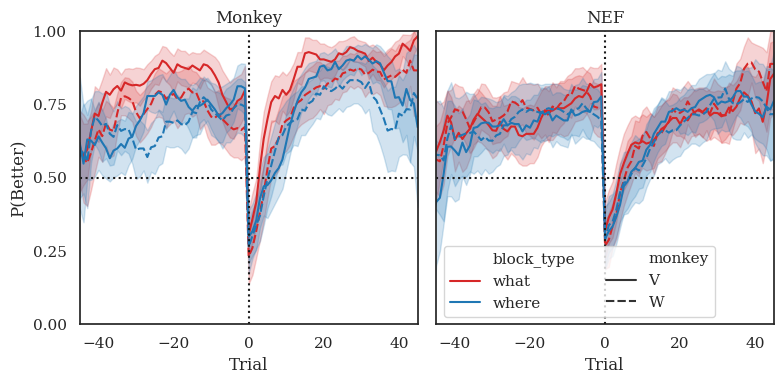

In [112]:
plot_dynamics(monkey_values_rev, nef_values, y='acc', xlim=[-45,45], ylabel='P(Better)')

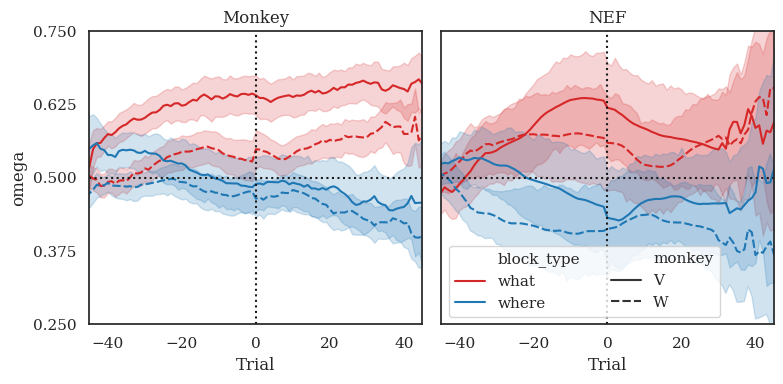

In [113]:
plot_dynamics(monkey_values_rev, nef_values, y='omega', xlim=[-45,45], ylim=[0.25, 0.75], ylabel='omega')

# Plot fraction of Q_total vs omega

In [92]:
def plot_fraction_Qtotal(nef_values, rl_values):
    nef_w = nef_values['omega'].to_numpy()
    nef_dvs = np.abs(nef_values['va'].to_numpy() - nef_values['vb'].to_numpy())
    nef_dva = np.abs(nef_values['vl'].to_numpy() - nef_values['vr'].to_numpy())
    nef_p_stim = nef_dvs / (nef_dvs + nef_dva)
    nef_p_act = nef_dva / (nef_dvs + nef_dva)
    
    rl_w = rl_values['omega'].to_numpy()
    rl_dvs = np.abs(rl_values['DeltaV_Stim'].to_numpy())
    rl_dva = np.abs(rl_values['DeltaV_Act'].to_numpy())
    rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
    rl_p_act = rl_dva / (rl_dvs + rl_dva)
    
    monkey_w = monkey_values['omega'].to_numpy()
    monkey_dvs = np.abs(monkey_values['DeltaV_Stim'].to_numpy())
    monkey_dva = np.abs(monkey_values['DeltaV_Act'].to_numpy())
    monkey_p_stim = monkey_dvs / (monkey_dvs + monkey_dva)
    monkey_p_act = monkey_dva / (monkey_dvs + monkey_dva)
    
    w_bins = np.linspace(0, 1, 20)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3), sharex=True, sharey=True)
    sns.regplot(x=rl_w, y=rl_p_stim, x_bins=w_bins, ax=axes[0], color=palette[0], scatter_kws={"s": 1}, label='RL')
    sns.regplot(x=rl_w, y=rl_p_act, x_bins=w_bins, ax=axes[1], color=palette[0], scatter_kws={"s": 1}, label='RL')
    sns.regplot(x=nef_w, y=nef_p_stim, x_bins=w_bins, ax=axes[0], color=palette[1], scatter_kws={"s": 1}, label='NEF')
    sns.regplot(x=nef_w, y=nef_p_act, x_bins=w_bins, ax=axes[1], color=palette[1], scatter_kws={"s": 1}, label='NEF')
    sns.regplot(x=monkey_w, y=monkey_p_stim, x_bins=w_bins, ax=axes[0], color=palette[2], scatter_kws={"s": 1}, label='Monkey')
    sns.regplot(x=monkey_w, y=monkey_p_act, x_bins=w_bins, ax=axes[1], color=palette[2], scatter_kws={"s": 1}, label='Monkey')
    axes[0].set(ylabel="Fraction of Q_total", xlim=(0.2, 0.8), ylim=(0, 1), title="Q_stim", xlabel='Omega')
    axes[1].set(xlim=(0.2, 0.8), ylim=(0, 1), title="Q_loc", xlabel='Omega')
    plt.tight_layout()

/tmp/ipykernel_2762433/3487888529.py:11: RuntimeWarning: invalid value encountered in divide
  rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
/tmp/ipykernel_2762433/3487888529.py:12: RuntimeWarning: invalid value encountered in divide
  rl_p_act = rl_dva / (rl_dvs + rl_dva)


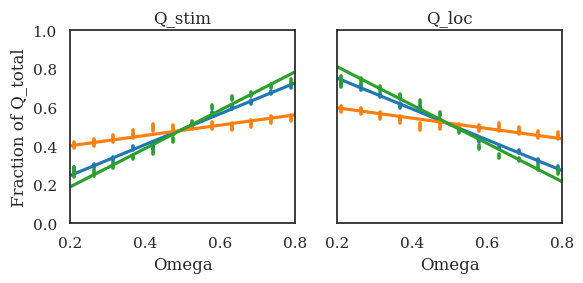

In [93]:
plot_fraction_Qtotal(nef_values, rl_values)

# Plot decoding acccuracy vs omega

In [94]:
def plot_decoding_accuracy_vs_omega_general(predicted_df, true_df, data_type='monkey'):
    """
    Generalized version for plotting decoding accuracy vs. omega.
    
    Parameters
    ----------
    predicted_df : pd.DataFrame
        Contains decoded values (from spikes)
    true_df : pd.DataFrame
        Contains ground-truth values (from RL or NEF model)
    data_type : str, {'monkey', 'nef'}
        Determines which column names to use and how to label the plot
    """
    # --- Determine column names depending on data type ---
    if data_type == 'monkey':
        x_cols = ['DeltaV_Act', 'DeltaV_Stim']
        xlabel = 'RL value\n(ground truth)'
        ylabel = 'Monkey value\n(decoded from spikes)'
    elif data_type == 'nef':
        x_cols = ['dva', 'dvs']
        xlabel = 'NEF value\n(ground truth)'
        ylabel = 'NEF value\n(decoded from spikes)'
    else:
        raise ValueError("data_type must be 'monkey' or 'nef'")

    # --- Bin omega values into 5 bins ---
    omega = true_df['omega']
    mask_low = omega < 0.45
    mask_high = omega > 0.55
    mask_mid = (omega >= 0.45) & (omega <= 0.55)
    med_low = omega[mask_low].median()
    med_high = omega[mask_high].median()
    
    true_df = true_df.copy()
    true_df['omega_bin'] = np.nan
    true_df.loc[mask_low & (omega <= med_low), 'omega_bin'] = 1
    true_df.loc[mask_low & (omega > med_low), 'omega_bin'] = 2
    true_df.loc[mask_mid, 'omega_bin'] = 3
    true_df.loc[mask_high & (omega <= med_high), 'omega_bin'] = 4
    true_df.loc[mask_high & (omega > med_high), 'omega_bin'] = 5
    true_df['omega_bin'] = true_df['omega_bin'].astype(int)

    # --- Merge predicted and true data ---
    combined = pd.merge(
        true_df[['monkey', 'session', 'block', 'trial', 'omega', 'omega_bin', x_cols[0], x_cols[1]]],
        predicted_df[['monkey', 'session', 'block', 'trial', x_cols[0], x_cols[1]]],
        on=['monkey', 'session', 'block', 'trial'],
        suffixes=('_true', '_pred')
    )

    # --- Plot setup ---
    palette = sns.color_palette("coolwarm", 5)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)

    for w, omega_bin in enumerate([1, 2, 3, 4, 5]):
        df_bin_act = combined.query("omega_bin == @omega_bin")[
            [f"{x_cols[0]}_true", f"{x_cols[0]}_pred"]
        ]
        df_bin_stim = combined.query("omega_bin == @omega_bin")[
            [f"{x_cols[1]}_true", f"{x_cols[1]}_pred"]
        ]

        # --- Compute R² ---
        if len(df_bin_act) > 1 and len(df_bin_stim) > 1:
            r2_act = r2_score(df_bin_act[f"{x_cols[0]}_true"], df_bin_act[f"{x_cols[0]}_pred"])
            r2_stim = r2_score(df_bin_stim[f"{x_cols[1]}_true"], df_bin_stim[f"{x_cols[1]}_pred"])
        else:
            r2_act, r2_stim = np.nan, np.nan

        # --- Plot regression lines (no scatter) ---
        sns.regplot(
            data=df_bin_act, x=f"{x_cols[0]}_true", y=f"{x_cols[0]}_pred",
            scatter=False, color=palette[w], ax=axes[0],
            label=rf"$\omega_{omega_bin}: R^2={r2_act:.2f}$"
        )
        sns.regplot(
            data=df_bin_stim, x=f"{x_cols[1]}_true", y=f"{x_cols[1]}_pred",
            scatter=False, color=palette[w], ax=axes[1],
            label=rf"$\omega_{omega_bin}: R^2={r2_stim:.2f}$"
        )

    # --- Axis labels and titles ---
    axes[0].set(xlabel=xlabel, ylabel=ylabel, title=r'$\Delta Q_{Act}$')
    axes[1].set(xlabel=xlabel, ylabel=None, title=r'$\Delta Q_{Stim}$')
    axes[0].legend()
    axes[1].legend()
    plt.tight_layout()
    plt.show()

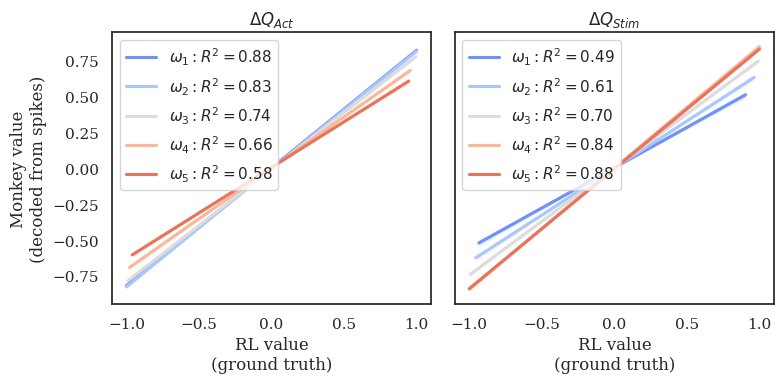

In [96]:
plot_decoding_accuracy_vs_omega_general(monkey_values, rl_values, data_type='monkey')

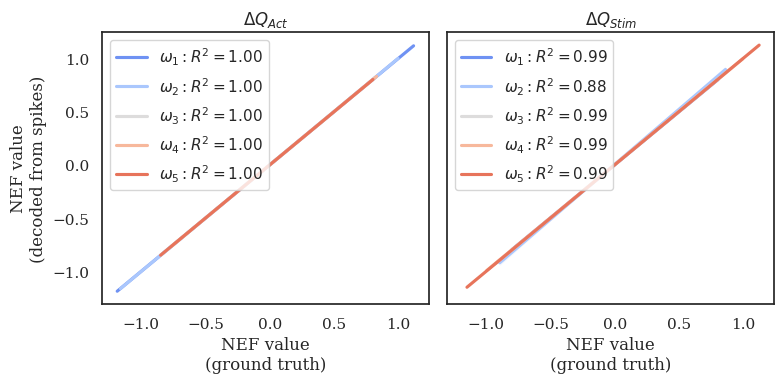

In [88]:
plot_decoding_accuracy_vs_omega_general(nef_values_cv, nef_values, data_type='nef')

In [115]:
import json
param_dict = {'V': {0: {'alpha_v': 0.5607,
           'gamma_v': 0.1963,
           'alpha_w': 0.1998,
           'w0': 0.5063,
           'gamma_w': 0.0},
       1: {'alpha_v': 0.3606,
           'gamma_v': 0.1684,
           'alpha_w': 0.2357,
           'w0': 0.5386,
           'gamma_w': 0.0184},
       2: {'alpha_v': 0.4093,
           'gamma_v': 0.1708,
           'alpha_w': 0.2146,
           'w0': 0.5379,
           'gamma_w': 0.0188},
       3: {'alpha_v': 0.3113,
           'gamma_v': 0.233,
           'alpha_w': 0.2634,
           'w0': 0.6616,
           'gamma_w': 0.0811}},
 'W': {0: {'alpha_v': 0.3301,
           'gamma_v': 0.3429,
           'alpha_w': 0.1693,
           'w0': 0.4887,
           'gamma_w': 0.0463},
       1: {'alpha_v': 0.4989,
           'gamma_v': 0.2323,
           'alpha_w': 0.352,
           'w0': 0.4769,
           'gamma_w': 0.0485},
       2: {'alpha_v': 0.5465,
           'gamma_v': 0.3315,
           'alpha_w': 0.3769,
           'w0': 0.5538,
           'gamma_w': 0.1429},
       3: {'alpha_v': 0.6062,
           'gamma_v': 0.2389,
           'alpha_w': 0.5503,
           'w0': 0.5014,
           'gamma_w': 0.0866}}}
with open("data/rl_fitted_params.json", "w") as f:
    json.dump(param_dict, f, indent=4)